In [2]:
import math
import numpy as np
import pandas as pd
import glob
import cv2

#import scikitplot
#import seaborn as sns
from matplotlib import pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report

import tensorflow as tf
from tensorflow.keras import optimizers
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Conv2D, MaxPooling2D
from tensorflow.keras.layers import Dropout, BatchNormalization, LeakyReLU, Activation
from tensorflow.keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras import utils

In [3]:
tf.test.is_gpu_available()

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


True

In [4]:
#df = pd.read_csv('../input/facial-expression-recognitionferchallenge/fer2013/fer2013/fer2013.csv')
#print(df.shape)
#df.head()

In [5]:
def label_creator():
    files = glob.glob('emotion_images/train/*/*')
    len(files)
    files[0:10]
    pixels = []
    emotions = []
    filename = []
    path2 = []
    for i in files:
        data = cv2.imread(i, 0).flatten()
        pixels.append(data)
        
        path = i.replace('\\', '/')
        path2.append(path)
        emotions.append(path.split('/')[2])

    
    outfile = list(zip(files, emotions, pixels))

    df = pd.DataFrame(outfile, columns = ['file', 'emotions', 'pixels'])
    
    df['emotions'].replace(['happy', 'sad', 'fear', 'surprise', 'neutral', 'angry', 'disgust'],
                        [0, 1,2,3,4,5,6], inplace=True)
    #df['emotion_value'] = df['emotion']
    #dummies = pd.get_dummies(df, columns = ['emotion'])
    #return dummies
    return df


In [6]:
df = label_creator()

In [7]:
df

,file,emotions,pixels
0,emotion_images/train\angry\Training_10118481.jpg,5,"[50, 32, 15, 11, 12, 10, 10, 8, 15, 10, 7, 7, ..."
1,emotion_images/train\angry\Training_10120469.jpg,5,"[29, 24, 29, 11, 15, 22, 26, 11, 7, 17, 29, 23..."
2,emotion_images/train\angry\Training_10131352.jpg,5,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,emotion_images/train\angry\Training_10161559.jpg,5,"[155, 138, 98, 112, 94, 97, 111, 107, 101, 84,..."
4,emotion_images/train\angry\Training_1021836.jpg,5,"[211, 215, 220, 221, 219, 216, 213, 210, 207, ..."
...,...,...,...
28704,emotion_images/train\surprise\Training_9991629...,3,"[27, 26, 26, 26, 27, 27, 28, 28, 33, 34, 35, 3..."
28705,emotion_images/train\surprise\Training_9992442...,3,"[7, 6, 13, 39, 76, 58, 29, 21, 16, 20, 34, 56,..."
28706,emotion_images/train\surprise\Training_9993700...,3,"[124, 129, 125, 123, 129, 128, 127, 128, 131, ..."
28707,emotion_images/train\surprise\Training_9995175...,3,"[242, 242, 242, 216, 110, 42, 20, 41, 37, 14, ..."


In [8]:
df['pixels'][0]

array([ 50,  32,  15, ..., 143, 136,  83], dtype=uint8)

In [9]:
df['emotions'].unique()

array([5, 6, 2, 0, 4, 1, 3], dtype=int64)

In [10]:
emotion_label_to_text = {0:'anger', 1:'disgust', 2:'fear', 3:'happiness', 4: 'sadness', 5: 'surprise', 6: 'neutral'}

In [11]:
df.emotions.value_counts()

0    7215
4    4965
1    4830
2    4097
5    3995
3    3171
6     436
Name: emotions, dtype: int64

In [12]:
#sns.countplot(df.emotion)
#pyplot.show()

`So majority classes belongs to 3:Happy, 4:Sad and 6:Neutral nd we are also intersted in these three classes only.`

In [13]:
math.sqrt(len(df.pixels[0]))

48.0

fig = pyplot.figure(1, (14, 14))

k = 0
for label in sorted(df.emotion.unique()):
    for j in range(7):
        px = df[df.emotion==label].pixels.iloc[k]
        px = np.array(px.split(' ')).reshape(48, 48).astype('float32')

        k += 1
        ax = pyplot.subplot(7, 7, k)
        ax.imshow(px, cmap='gray')
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(emotion_label_to_text[label])
        pyplot.tight_layout()

In [14]:
INTERESTED_LABELS = [0,1,4]

In [15]:
df = df[df.emotions.isin(INTERESTED_LABELS)]
df.shape

(17010, 3)

In [16]:
df.head()

,file,emotions,pixels
8528,emotion_images/train\happy\Training_10019449.jpg,0,"[255, 254, 255, 252, 255, 253, 255, 233, 134, ..."
8529,emotion_images/train\happy\Training_10046809.jpg,0,"[42, 56, 60, 64, 60, 72, 77, 83, 96, 109, 92, ..."
8530,emotion_images/train\happy\Training_10066226.jpg,0,"[15, 13, 14, 26, 21, 45, 77, 91, 108, 123, 127..."
8531,emotion_images/train\happy\Training_10070997.jpg,0,"[152, 132, 132, 147, 174, 157, 137, 123, 139, ..."
8532,emotion_images/train\happy\Training_10080933.jpg,0,"[252, 254, 255, 252, 252, 248, 233, 218, 208, ..."


In [17]:
df = df.sample(frac = 1)

In [18]:
df

,file,emotions,pixels
11107,emotion_images/train\happy\Training_42104843.jpg,0,"[175, 156, 128, 130, 141, 144, 150, 167, 182, ..."
18423,emotion_images/train\neutral\Training_58198728...,4,"[13, 20, 15, 20, 23, 37, 35, 146, 132, 45, 30,..."
10837,emotion_images/train\happy\Training_38700351.jpg,0,"[213, 161, 144, 142, 136, 144, 149, 152, 154, ..."
19923,emotion_images/train\neutral\Training_8582026.jpg,4,"[171, 122, 97, 105, 119, 113, 130, 112, 98, 12..."
12049,emotion_images/train\happy\Training_53721417.jpg,0,"[11, 7, 8, 18, 7, 3, 11, 5, 1, 43, 86, 91, 92,..."
...,...,...,...
21457,emotion_images/train\sad\Training_23680663.jpg,1,"[43, 51, 64, 81, 103, 121, 135, 144, 148, 159,..."
14731,emotion_images/train\happy\Training_87264328.jpg,0,"[169, 166, 168, 160, 186, 178, 147, 180, 170, ..."
15718,emotion_images/train\happy\Training_99666856.jpg,0,"[249, 250, 248, 240, 182, 123, 133, 89, 60, 61..."
16148,emotion_images/train\neutral\Training_16847290...,4,"[164, 165, 173, 168, 165, 173, 175, 180, 189, ..."


`Now I will make the data compatible for neural networks.`

In [19]:
img_array = df.pixels.apply(lambda x: np.array(x).reshape(48, 48, 1).astype('float32'))
img_array = np.stack(img_array, axis=0)

In [20]:
img_array.shape

(17010, 48, 48, 1)

In [21]:
le = LabelEncoder()
img_labels = le.fit_transform(df.emotions)
img_labels = utils.to_categorical(img_labels)
img_labels.shape

(17010, 3)

In [22]:
img_labels

array([[1., 0., 0.],
       [0., 0., 1.],
       [1., 0., 0.],
       ...,
       [1., 0., 0.],
       [0., 0., 1.],
       [1., 0., 0.]], dtype=float32)

In [23]:
le_name_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
print(le_name_mapping)

{0: 0, 1: 1, 4: 2}


`Splitting the data into training and validation set.`

In [24]:
X_train, X_valid, y_train, y_valid = train_test_split(img_array, img_labels,
                                                    shuffle=True, stratify=img_labels,
                                                    test_size=0.1, random_state=42)
X_train.shape, X_valid.shape, y_train.shape, y_valid.shape

((15309, 48, 48, 1), (1701, 48, 48, 1), (15309, 3), (1701, 3))

In [25]:
del df
del img_array
del img_labels

In [26]:
img_width = X_train.shape[1]
img_height = X_train.shape[2]
img_depth = X_train.shape[3]
num_classes = y_train.shape[1]

In [27]:
# Normalizing results, as neural networks are very sensitive to unnormalized data.
X_train = X_train / 255.
X_valid = X_valid / 255.

In [28]:
def build_net(optim):
    """
    This is a Deep Convolutional Neural Network (DCNN). For generalization purpose I used dropouts in regular intervals.
    I used `ELU` as the activation because it avoids dying relu problem but also performed well as compared to LeakyRelu
    atleast in this case. `he_normal` kernel initializer is used as it suits ELU. BatchNormalization is also used for better
    results.
    """
    net = Sequential(name='DCNN')

    net.add(
        Conv2D(
            filters=64,
            kernel_size=(5,5),
            input_shape=(img_width, img_height, img_depth),
            activation='elu',
            padding='same',
            kernel_initializer='he_normal',
            name='conv2d_1'
        )
    )
    net.add(BatchNormalization(name='batchnorm_1'))
    net.add(
        Conv2D(
            filters=64,
            kernel_size=(5,5),
            activation='elu',
            padding='same',
            kernel_initializer='he_normal',
            name='conv2d_2'
        )
    )
    net.add(BatchNormalization(name='batchnorm_2'))
    
    net.add(MaxPooling2D(pool_size=(2,2), name='maxpool2d_1'))
    net.add(Dropout(0.4, name='dropout_1'))

    net.add(
        Conv2D(
            filters=128,
            kernel_size=(3,3),
            activation='elu',
            padding='same',
            kernel_initializer='he_normal',
            name='conv2d_3'
        )
    )
    net.add(BatchNormalization(name='batchnorm_3'))
    net.add(
        Conv2D(
            filters=128,
            kernel_size=(3,3),
            activation='elu',
            padding='same',
            kernel_initializer='he_normal',
            name='conv2d_4'
        )
    )
    net.add(BatchNormalization(name='batchnorm_4'))
    
    net.add(MaxPooling2D(pool_size=(2,2), name='maxpool2d_2'))
    net.add(Dropout(0.4, name='dropout_2'))

    net.add(
        Conv2D(
            filters=256,
            kernel_size=(3,3),
            activation='elu',
            padding='same',
            kernel_initializer='he_normal',
            name='conv2d_5'
        )
    )
    net.add(BatchNormalization(name='batchnorm_5'))
    net.add(
        Conv2D(
            filters=256,
            kernel_size=(3,3),
            activation='elu',
            padding='same',
            kernel_initializer='he_normal',
            name='conv2d_6'
        )
    )
    net.add(BatchNormalization(name='batchnorm_6'))
    
    net.add(MaxPooling2D(pool_size=(2,2), name='maxpool2d_3'))
    net.add(Dropout(0.5, name='dropout_3'))

    net.add(Flatten(name='flatten'))
        
    net.add(
        Dense(
            128,
            activation='elu',
            kernel_initializer='he_normal',
            name='dense_1'
        )
    )
    net.add(BatchNormalization(name='batchnorm_7'))
    
    net.add(Dropout(0.6, name='dropout_4'))
    
    net.add(
        Dense(
            num_classes,
            activation='softmax',
            name='out_layer'
        )
    )
    
    net.compile(
        loss='categorical_crossentropy',
        optimizer=optim,
        metrics=['accuracy']
    )
    
    net.summary()
    
    return net

In [29]:
def build_net2(optim):
    """
    added another layer of conv2d and batchnorm to each convolution layer. kept the network the same after flattening
    
    
    
    This is a Deep Convolutional Neural Network (DCNN). For generalization purpose I used dropouts in regular intervals.
    I used `ELU` as the activation because it avoids dying relu problem but also performed well as compared to LeakyRelu
    atleast in this case. `he_normal` kernel initializer is used as it suits ELU. BatchNormalization is also used for better
    results.
    """
    net = Sequential(name='DCNN')

    net.add(
        Conv2D(
            filters=64,
            kernel_size=(5,5),
            input_shape=(img_width, img_height, img_depth),
            activation='elu',
            padding='same',
            kernel_initializer='he_normal',
            name='conv2d_1.1'
        )
    )
    net.add(BatchNormalization(name='batchnorm_1.1'))
    
    net.add(
        Conv2D(
            filters=64,
            kernel_size=(5,5),
            activation='elu',
            padding='same',
            kernel_initializer='he_normal',
            name='conv2d_1.2'
        )
    )
    net.add(BatchNormalization(name='batchnorm_1.2'))
    
    net.add(
        Conv2D(
            filters=64,
            kernel_size=(5,5),
            activation='elu',
            padding='same',
            kernel_initializer='he_normal',
            name='conv2d_1.3'
        )
    )
    net.add(BatchNormalization(name='batchnorm_1.3'))
    
    net.add(MaxPooling2D(pool_size=(2,2), name='maxpool2d_1'))
    
    net.add(Dropout(0.4, name='dropout_1'))

    net.add(
        Conv2D(
            filters=128,
            kernel_size=(3,3),
            activation='elu',
            padding='same',
            kernel_initializer='he_normal',
            name='conv2d_2.1'
        )
    )
    net.add(BatchNormalization(name='batchnorm_2.1'))
    net.add(
        Conv2D(
            filters=128,
            kernel_size=(3,3),
            activation='elu',
            padding='same',
            kernel_initializer='he_normal',
            name='conv2d_2.2'
        )
    )
    net.add(BatchNormalization(name='batchnorm_2.2'))
    
    net.add(
        Conv2D(
            filters=128,
            kernel_size=(3,3),
            activation='elu',
            padding='same',
            kernel_initializer='he_normal',
            name='conv2d_2.3'
        )
    )
    net.add(BatchNormalization(name='batchnorm_2.3'))
    
    net.add(MaxPooling2D(pool_size=(2,2), name='maxpool2d_2'))
    net.add(Dropout(0.4, name='dropout_2'))

    net.add(
        Conv2D(
            filters=256,
            kernel_size=(3,3),
            activation='elu',
            padding='same',
            kernel_initializer='he_normal',
            name='conv2d_3.1'
        )
    )
    net.add(BatchNormalization(name='batchnorm_3.1'))
    
    net.add(
        Conv2D(
            filters=256,
            kernel_size=(3,3),
            activation='elu',
            padding='same',
            kernel_initializer='he_normal',
            name='conv2d_3.2'
        )
    )
    net.add(BatchNormalization(name='batchnorm_3.2'))
    
    
    net.add(
        Conv2D(
            filters=256,
            kernel_size=(3,3),
            activation='elu',
            padding='same',
            kernel_initializer='he_normal',
            name='conv2d_3.3'
        )
    )
    net.add(BatchNormalization(name='batchnorm_3.3'))
    
    net.add(MaxPooling2D(pool_size=(2,2), name='maxpool2d_3'))
    net.add(Dropout(0.5, name='dropout_3'))

    net.add(Flatten(name='flatten'))
        
    net.add(
        Dense(
            128,
            activation='elu',
            kernel_initializer='he_normal',
            name='dense_1'
        )
    )
    net.add(BatchNormalization(name='batchnorm_7'))
    
    net.add(Dropout(0.6, name='dropout_4'))
    
    net.add(
        Dense(
            num_classes,
            activation='softmax',
            name='out_layer'
        )
    )
    
    net.compile(
        loss='categorical_crossentropy',
        optimizer=optim,
        metrics=['accuracy']
    )
    
    net.summary()
    
    return net

In [30]:
def build_net3(optim):
    """
    same as network 2 but added some more hidden layers after flattening
    
    
    
    This is a Deep Convolutional Neural Network (DCNN). For generalization purpose I used dropouts in regular intervals.
    I used `ELU` as the activation because it avoids dying relu problem but also performed well as compared to LeakyRelu
    atleast in this case. `he_normal` kernel initializer is used as it suits ELU. BatchNormalization is also used for better
    results.
    """
    net = Sequential(name='DCNN')

    net.add(
        Conv2D(
            filters=64,
            kernel_size=(5,5),
            input_shape=(img_width, img_height, img_depth),
            activation='elu',
            padding='same',
            kernel_initializer='he_normal',
            name='conv2d_1.1'
        )
    )
    net.add(BatchNormalization(name='batchnorm_1.1'))
    
    net.add(
        Conv2D(
            filters=64,
            kernel_size=(5,5),
            activation='elu',
            padding='same',
            kernel_initializer='he_normal',
            name='conv2d_1.2'
        )
    )
    net.add(BatchNormalization(name='batchnorm_1.2'))
    
    net.add(
        Conv2D(
            filters=64,
            kernel_size=(5,5),
            activation='elu',
            padding='same',
            kernel_initializer='he_normal',
            name='conv2d_1.3'
        )
    )
    net.add(BatchNormalization(name='batchnorm_1.3'))
    
    net.add(MaxPooling2D(pool_size=(2,2), name='maxpool2d_1'))
    
    net.add(Dropout(0.4, name='dropout_1'))

    net.add(
        Conv2D(
            filters=128,
            kernel_size=(3,3),
            activation='elu',
            padding='same',
            kernel_initializer='he_normal',
            name='conv2d_2.1'
        )
    )
    net.add(BatchNormalization(name='batchnorm_2.1'))
    net.add(
        Conv2D(
            filters=128,
            kernel_size=(3,3),
            activation='elu',
            padding='same',
            kernel_initializer='he_normal',
            name='conv2d_2.2'
        )
    )
    net.add(BatchNormalization(name='batchnorm_2.2'))
    
    net.add(
        Conv2D(
            filters=128,
            kernel_size=(3,3),
            activation='elu',
            padding='same',
            kernel_initializer='he_normal',
            name='conv2d_2.3'
        )
    )
    net.add(BatchNormalization(name='batchnorm_2.3'))
    
    net.add(MaxPooling2D(pool_size=(2,2), name='maxpool2d_2'))
    net.add(Dropout(0.4, name='dropout_2'))

    net.add(
        Conv2D(
            filters=256,
            kernel_size=(3,3),
            activation='elu',
            padding='same',
            kernel_initializer='he_normal',
            name='conv2d_3.1'
        )
    )
    net.add(BatchNormalization(name='batchnorm_3.1'))
    
    net.add(
        Conv2D(
            filters=256,
            kernel_size=(3,3),
            activation='elu',
            padding='same',
            kernel_initializer='he_normal',
            name='conv2d_3.2'
        )
    )
    net.add(BatchNormalization(name='batchnorm_3.2'))
    
    
    net.add(
        Conv2D(
            filters=256,
            kernel_size=(3,3),
            activation='elu',
            padding='same',
            kernel_initializer='he_normal',
            name='conv2d_3.3'
        )
    )
    net.add(BatchNormalization(name='batchnorm_3.3'))
    
    net.add(MaxPooling2D(pool_size=(2,2), name='maxpool2d_3'))
    net.add(Dropout(0.5, name='dropout_3'))

    net.add(Flatten(name='flatten'))
        
    net.add(
        Dense(
            128,
            activation='elu',
            kernel_initializer='he_normal',
            name='dense_1'
        )
    )
    net.add(BatchNormalization(name='batchnorm_7'))
    
    net.add(Dropout(0.6, name='dropout_4'))
    
    
    net.add(
        Dense(
            128,
            activation='elu',
            kernel_initializer='he_normal',
            name='dense_1.2'
        )
    )
    net.add(BatchNormalization(name='batchnorm_7.2'))
    
    net.add(Dropout(0.6, name='dropout_4.2'))
    
    
    net.add(
        Dense(
            128,
            activation='elu',
            kernel_initializer='he_normal',
            name='dense_1.3'
        )
    )
    net.add(BatchNormalization(name='batchnorm_7.3'))
    
    net.add(Dropout(0.6, name='dropout_4.3'))
    
    
    
    net.add(
        Dense(
            num_classes,
            activation='softmax',
            name='out_layer'
        )
    )
    
    net.compile(
        loss='categorical_crossentropy',
        optimizer=optim,
        metrics=['accuracy']
    )
    
    net.summary()
    
    return net

In [31]:
def build_net4(optim):
    """same as above but removed all dropout and batchnorm from convolution layers"""
    
    net = Sequential(name='DCNN')

    net.add(
        Conv2D(
            filters=64,
            kernel_size=(5,5),
            input_shape=(img_width, img_height, img_depth),
            activation='elu',
            padding='same',
            kernel_initializer='he_normal',
            name='conv2d_1.1'
        )
    )

    net.add(
        Conv2D(
            filters=64,
            kernel_size=(5,5),
            activation='elu',
            padding='same',
            kernel_initializer='he_normal',
            name='conv2d_1.2'
        )
    )

    net.add(
        Conv2D(
            filters=64,
            kernel_size=(5,5),
            activation='elu',
            padding='same',
            kernel_initializer='he_normal',
            name='conv2d_1.3'
        )
    )

    net.add(MaxPooling2D(pool_size=(2,2), name='maxpool2d_1'))
    

    net.add(
        Conv2D(
            filters=128,
            kernel_size=(3,3),
            activation='elu',
            padding='same',
            kernel_initializer='he_normal',
            name='conv2d_2.1'
        )
    )
    
    net.add(
        Conv2D(
            filters=128,
            kernel_size=(3,3),
            activation='elu',
            padding='same',
            kernel_initializer='he_normal',
            name='conv2d_2.2'
        )
    )

    net.add(
        Conv2D(
            filters=128,
            kernel_size=(3,3),
            activation='elu',
            padding='same',
            kernel_initializer='he_normal',
            name='conv2d_2.3'
        )
    )
    net.add(MaxPooling2D(pool_size=(2,2), name='maxpool2d_2'))

    net.add(
        Conv2D(
            filters=256,
            kernel_size=(3,3),
            activation='elu',
            padding='same',
            kernel_initializer='he_normal',
            name='conv2d_3.1'
        )
    )

    net.add(
        Conv2D(
            filters=256,
            kernel_size=(3,3),
            activation='elu',
            padding='same',
            kernel_initializer='he_normal',
            name='conv2d_3.2'
        )
    )

    net.add(
        Conv2D(
            filters=256,
            kernel_size=(3,3),
            activation='elu',
            padding='same',
            kernel_initializer='he_normal',
            name='conv2d_3.3'
        )
    )

    
    net.add(MaxPooling2D(pool_size=(2,2), name='maxpool2d_3'))


    net.add(Flatten(name='flatten'))
        
    net.add(
        Dense(
            128,
            activation='elu',
            kernel_initializer='he_normal',
            name='dense_1'
        )
    )
    net.add(BatchNormalization(name='batchnorm_7'))
    
    net.add(Dropout(0.6, name='dropout_4'))
    
    
    net.add(
        Dense(
            128,
            activation='elu',
            kernel_initializer='he_normal',
            name='dense_1.2'
        )
    )
    net.add(BatchNormalization(name='batchnorm_7.2'))
    
    net.add(Dropout(0.6, name='dropout_4.2'))
    
    
    net.add(
        Dense(
            128,
            activation='elu',
            kernel_initializer='he_normal',
            name='dense_1.3'
        )
    )
    net.add(BatchNormalization(name='batchnorm_7.3'))
    
    net.add(Dropout(0.6, name='dropout_4.3'))
    
    
    
    net.add(
        Dense(
            num_classes,
            activation='softmax',
            name='out_layer'
        )
    )
    
    net.compile(
        loss='categorical_crossentropy',
        optimizer=optim,
        metrics=['accuracy']
    )
    
    net.summary()
    
    return net

In [32]:
def build_net5(optim):
    """ only removed the last convolutional layer"""
    net = Sequential(name='DCNN')

    net.add(
        Conv2D(
            filters=64,
            kernel_size=(5,5),
            input_shape=(img_width, img_height, img_depth),
            activation='elu',
            padding='same',
            kernel_initializer='he_normal',
            name='conv2d_1'
        )
    )
    net.add(BatchNormalization(name='batchnorm_1'))
    net.add(
        Conv2D(
            filters=64,
            kernel_size=(5,5),
            activation='elu',
            padding='same',
            kernel_initializer='he_normal',
            name='conv2d_2'
        )
    )
    net.add(BatchNormalization(name='batchnorm_2'))
    
    net.add(MaxPooling2D(pool_size=(2,2), name='maxpool2d_1'))
    net.add(Dropout(0.4, name='dropout_1'))

    net.add(
        Conv2D(
            filters=128,
            kernel_size=(3,3),
            activation='elu',
            padding='same',
            kernel_initializer='he_normal',
            name='conv2d_3'
        )
    )
    net.add(BatchNormalization(name='batchnorm_3'))
    net.add(
        Conv2D(
            filters=128,
            kernel_size=(3,3),
            activation='elu',
            padding='same',
            kernel_initializer='he_normal',
            name='conv2d_4'
        )
    )
    net.add(BatchNormalization(name='batchnorm_4'))
    
    net.add(MaxPooling2D(pool_size=(2,2), name='maxpool2d_2'))
    net.add(Dropout(0.4, name='dropout_2'))


    net.add(Flatten(name='flatten'))
        
    net.add(
        Dense(
            128,
            activation='elu',
            kernel_initializer='he_normal',
            name='dense_1'
        )
    )
    net.add(BatchNormalization(name='batchnorm_7'))
    
    net.add(Dropout(0.6, name='dropout_4'))
    
    net.add(
        Dense(
            num_classes,
            activation='softmax',
            name='out_layer'
        )
    )
    
    net.compile(
        loss='categorical_crossentropy',
        optimizer=optim,
        metrics=['accuracy']
    )
    
    net.summary()
    
    return net
    

In [33]:
def build_net6(optim):
    """basic model with only 3 conv layers and 3 pooling layers before being flattened"""
    net = Sequential(name='DCNN')

    net.add(
        Conv2D(
            filters=64,
            kernel_size=(5,5),
            input_shape=(img_width, img_height, img_depth),
            activation='elu',
            padding='same',
            kernel_initializer='he_normal',
            name='conv2d_1'
        )
    )

    net.add(MaxPooling2D(pool_size=(2,2), name='maxpool2d_1'))


    net.add(
        Conv2D(
            filters=128,
            kernel_size=(3,3),
            activation='elu',
            padding='same',
            kernel_initializer='he_normal',
            name='conv2d_2'
        )
    )

    net.add(MaxPooling2D(pool_size=(2,2), name='maxpool2d_2'))

    net.add(
        Conv2D(
            filters=128,
            kernel_size=(3,3),
            activation='elu',
            padding='same',
            kernel_initializer='he_normal',
            name='conv2d_3'
        )
    )

    net.add(MaxPooling2D(pool_size=(2,2), name='maxpool2d_3'))

    
    
    net.add(Flatten(name='flatten'))
        
    net.add(
        Dense(
            128,
            activation='elu',
            kernel_initializer='he_normal',
            name='dense_1'
        )
    )
    net.add(BatchNormalization(name='batchnorm_7'))
    
    net.add(Dropout(0.6, name='dropout_4'))
    
    net.add(
        Dense(
            num_classes,
            activation='softmax',
            name='out_layer'
        )
    )
    
    net.compile(
        loss='categorical_crossentropy',
        optimizer=optim,
        metrics=['accuracy']
    )
    
    net.summary()
    
    return net

In [34]:
def build_net7(optim):
    """
    added another layer of conv2d and batchnorm to each convolution layer. kept the network the same after flattening
    
    
    
    This is a Deep Convolutional Neural Network (DCNN). For generalization purpose I used dropouts in regular intervals.
    I used `ELU` as the activation because it avoids dying relu problem but also performed well as compared to LeakyRelu
    atleast in this case. `he_normal` kernel initializer is used as it suits ELU. BatchNormalization is also used for better
    results.
    """
    net = Sequential(name='DCNN')

    net.add(
        Conv2D(
            filters=64,
            kernel_size=(5,5),
            input_shape=(img_width, img_height, img_depth),
            activation='elu',
            padding='same',
            kernel_initializer='he_normal',
            name='conv2d_1.1'
        )
    )
    net.add(BatchNormalization(name='batchnorm_1.1'))
    
    net.add(
        Conv2D(
            filters=64,
            kernel_size=(5,5),
            activation='elu',
            padding='same',
            kernel_initializer='he_normal',
            name='conv2d_1.2'
        )
    )
    net.add(BatchNormalization(name='batchnorm_1.2'))
    
    net.add(
        Conv2D(
            filters=64,
            kernel_size=(5,5),
            activation='elu',
            padding='same',
            kernel_initializer='he_normal',
            name='conv2d_1.3'
        )
    )
    net.add(BatchNormalization(name='batchnorm_1.3'))
    
    net.add(
        Conv2D(
            filters=64,
            kernel_size=(5,5),
            activation='elu',
            padding='same',
            kernel_initializer='he_normal',
            name='conv2d_1.4'
        )
    )
    net.add(BatchNormalization(name='batchnorm_1.4'))
    
    net.add(MaxPooling2D(pool_size=(2,2), name='maxpool2d_1'))
    
    net.add(Dropout(0.4, name='dropout_1'))

    net.add(
        Conv2D(
            filters=128,
            kernel_size=(3,3),
            activation='elu',
            padding='same',
            kernel_initializer='he_normal',
            name='conv2d_2.1'
        )
    )
    net.add(BatchNormalization(name='batchnorm_2.1'))
    net.add(
        Conv2D(
            filters=128,
            kernel_size=(3,3),
            activation='elu',
            padding='same',
            kernel_initializer='he_normal',
            name='conv2d_2.2'
        )
    )
    net.add(BatchNormalization(name='batchnorm_2.2'))
    
    net.add(
        Conv2D(
            filters=128,
            kernel_size=(3,3),
            activation='elu',
            padding='same',
            kernel_initializer='he_normal',
            name='conv2d_2.3'
        )
    )
    net.add(BatchNormalization(name='batchnorm_2.3'))
    
    
    net.add(
        Conv2D(
            filters=128,
            kernel_size=(3,3),
            activation='elu',
            padding='same',
            kernel_initializer='he_normal',
            name='conv2d_2.4'
        )
    )
    net.add(BatchNormalization(name='batchnorm_2.4'))
    
    net.add(MaxPooling2D(pool_size=(2,2), name='maxpool2d_2'))
    net.add(Dropout(0.4, name='dropout_2'))

    net.add(
        Conv2D(
            filters=256,
            kernel_size=(3,3),
            activation='elu',
            padding='same',
            kernel_initializer='he_normal',
            name='conv2d_3.1'
        )
    )
    net.add(BatchNormalization(name='batchnorm_3.1'))
    
    net.add(
        Conv2D(
            filters=256,
            kernel_size=(3,3),
            activation='elu',
            padding='same',
            kernel_initializer='he_normal',
            name='conv2d_3.2'
        )
    )
    net.add(BatchNormalization(name='batchnorm_3.2'))
    
    
    net.add(
        Conv2D(
            filters=256,
            kernel_size=(3,3),
            activation='elu',
            padding='same',
            kernel_initializer='he_normal',
            name='conv2d_3.3'
        )
    )
    net.add(BatchNormalization(name='batchnorm_3.3'))
    
    
    net.add(
        Conv2D(
            filters=256,
            kernel_size=(3,3),
            activation='elu',
            padding='same',
            kernel_initializer='he_normal',
            name='conv2d_3.4'
        )
    )
    net.add(BatchNormalization(name='batchnorm_3.4'))
    
    
    net.add(MaxPooling2D(pool_size=(2,2), name='maxpool2d_3'))
    net.add(Dropout(0.5, name='dropout_3'))

    net.add(Flatten(name='flatten'))
        
    net.add(
        Dense(
            128,
            activation='elu',
            kernel_initializer='he_normal',
            name='dense_1'
        )
    )
    net.add(BatchNormalization(name='batchnorm_7'))
    
    net.add(Dropout(0.6, name='dropout_4'))
    
    
    
    net.add(
        Dense(
            128,
            activation='elu',
            kernel_initializer='he_normal',
            name='dense_2'
        )
    )
    net.add(BatchNormalization(name='batchnorm_8'))
    
    net.add(Dropout(0.6, name='dropout_5'))
    
    
    
    
    net.add(
        Dense(
            num_classes,
            activation='softmax',
            name='out_layer'
        )
    )
    
    net.compile(
        loss='categorical_crossentropy',
        optimizer=optim,
        metrics=['accuracy']
    )
    
    net.summary()
    
    return net

In [35]:
"""
I used two callbacks one is `early stopping` for avoiding overfitting training data
and other `ReduceLROnPlateau` for learning rate.
"""

early_stopping = EarlyStopping(
    monitor='val_accuracy',
    min_delta=0.00005,
    patience=11,
    verbose=1,
    restore_best_weights=True,
)

lr_scheduler = ReduceLROnPlateau(
    monitor='val_accuracy',
    factor=0.5,
    patience=7,
    min_lr=1e-7,
    verbose=1,
)

callbacks = [
    early_stopping,
    lr_scheduler,
]

In [36]:
# As the data in hand is less as compared to the task so ImageDataGenerator is good to go.
train_datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.15,
    height_shift_range=0.15,
    shear_range=0.15,
    zoom_range=0.15,
    horizontal_flip=True,
)
train_datagen.fit(X_train)

In [37]:
batch_size = 32 #batch size of 32 performs the best.
epochs = 100
optims = [
    optimizers.Nadam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07, name='Nadam'),
    optimizers.Adam(0.001),
]



In [37]:
# I tried both `Nadam` and `Adam`, the difference in results is not different but I finally went with Nadam as it is more popular.
model = build_net(optims[1]) 
history = model.fit_generator(
    train_datagen.flow(X_train, y_train, batch_size=batch_size),
    validation_data=(X_valid, y_valid),
    steps_per_epoch=len(X_train) / batch_size,
    epochs=epochs,
    callbacks=callbacks
)

Model: "DCNN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 48, 48, 64)        1664      
_________________________________________________________________
batchnorm_1 (BatchNormalizat (None, 48, 48, 64)        256       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 48, 48, 64)        102464    
_________________________________________________________________
batchnorm_2 (BatchNormalizat (None, 48, 48, 64)        256       
_________________________________________________________________
maxpool2d_1 (MaxPooling2D)   (None, 24, 24, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 24, 24, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 24, 24, 128)       73856  

C:\Users\joelw\anaconda3\envs\tfgpu\lib\site-packages\tensorflow\python\keras\engine\training.py:1969: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


478/478 [==============================] - 16s 27ms/step - loss: 1.3296 - accuracy: 0.3938 - val_loss: 1.0262 - val_accuracy: 0.4744
Epoch 2/100
478/478 [==============================] - 12s 25ms/step - loss: 1.0464 - accuracy: 0.4684 - val_loss: 0.9714 - val_accuracy: 0.5209
Epoch 3/100
478/478 [==============================] - 12s 25ms/step - loss: 0.9703 - accuracy: 0.5238 - val_loss: 0.8387 - val_accuracy: 0.5955
Epoch 4/100
478/478 [==============================] - 12s 25ms/step - loss: 0.9022 - accuracy: 0.5607 - val_loss: 0.7274 - val_accuracy: 0.6626
Epoch 5/100
478/478 [==============================] - 12s 25ms/step - loss: 0.8296 - accuracy: 0.6043 - val_loss: 0.7066 - val_accuracy: 0.6855
Epoch 6/100
478/478 [==============================] - 12s 25ms/step - loss: 0.7766 - accuracy: 0.6365 - val_loss: 0.7440 - val_accuracy: 0.6626
Epoch 7/100
478/478 [==============================] - 12s 25ms/step - loss: 0.7337 - accuracy: 0.6639 - val_loss: 0.6259 - val_accuracy: 0.71

Epoch 57/100
478/478 [==============================] - 12s 25ms/step - loss: 0.4255 - accuracy: 0.8279 - val_loss: 0.4949 - val_accuracy: 0.8095
Epoch 58/100
478/478 [==============================] - 12s 25ms/step - loss: 0.4212 - accuracy: 0.8279 - val_loss: 0.4895 - val_accuracy: 0.8019
Epoch 59/100
478/478 [==============================] - 12s 25ms/step - loss: 0.4199 - accuracy: 0.8326 - val_loss: 0.4942 - val_accuracy: 0.8036
Epoch 60/100
478/478 [==============================] - 12s 25ms/step - loss: 0.4220 - accuracy: 0.8289 - val_loss: 0.4707 - val_accuracy: 0.8113

Epoch 00060: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
Epoch 61/100
478/478 [==============================] - 12s 25ms/step - loss: 0.4104 - accuracy: 0.8357 - val_loss: 0.4823 - val_accuracy: 0.8131
Epoch 62/100
478/478 [==============================] - 12s 25ms/step - loss: 0.4104 - accuracy: 0.8374 - val_loss: 0.4889 - val_accuracy: 0.8054
Epoch 63/100
478/478 [=====================

In [38]:
# I tried both `Nadam` and `Adam`, the difference in results is not different but I finally went with Nadam as it is more popular.
model2 = build_net2(optims[1]) 
history2 = model2.fit_generator(
    train_datagen.flow(X_train, y_train, batch_size=batch_size),
    validation_data=(X_valid, y_valid),
    steps_per_epoch=len(X_train) / batch_size,
    epochs=epochs,
    callbacks=callbacks
)

Model: "DCNN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1.1 (Conv2D)          (None, 48, 48, 64)        1664      
_________________________________________________________________
batchnorm_1.1 (BatchNormaliz (None, 48, 48, 64)        256       
_________________________________________________________________
conv2d_1.2 (Conv2D)          (None, 48, 48, 64)        102464    
_________________________________________________________________
batchnorm_1.2 (BatchNormaliz (None, 48, 48, 64)        256       
_________________________________________________________________
conv2d_1.3 (Conv2D)          (None, 48, 48, 64)        102464    
_________________________________________________________________
batchnorm_1.3 (BatchNormaliz (None, 48, 48, 64)        256       
_________________________________________________________________
maxpool2d_1 (MaxPooling2D)   (None, 24, 24, 64)        0      

In [39]:
# I tried both `Nadam` and `Adam`, the difference in results is not different but I finally went with Nadam as it is more popular.
model3 = build_net3(optims[1]) 
history3 = model3.fit_generator(
    train_datagen.flow(X_train, y_train, batch_size=batch_size),
    validation_data=(X_valid, y_valid),
    steps_per_epoch=len(X_train) / batch_size,
    epochs=epochs,
    callbacks=callbacks
)

Model: "DCNN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1.1 (Conv2D)          (None, 48, 48, 64)        1664      
_________________________________________________________________
batchnorm_1.1 (BatchNormaliz (None, 48, 48, 64)        256       
_________________________________________________________________
conv2d_1.2 (Conv2D)          (None, 48, 48, 64)        102464    
_________________________________________________________________
batchnorm_1.2 (BatchNormaliz (None, 48, 48, 64)        256       
_________________________________________________________________
conv2d_1.3 (Conv2D)          (None, 48, 48, 64)        102464    
_________________________________________________________________
batchnorm_1.3 (BatchNormaliz (None, 48, 48, 64)        256       
_________________________________________________________________
maxpool2d_1 (MaxPooling2D)   (None, 24, 24, 64)        0      

478/478 [==============================] - 18s 37ms/step - loss: 0.8798 - accuracy: 0.5741 - val_loss: 0.8551 - val_accuracy: 0.6091
Epoch 24/100
478/478 [==============================] - 18s 37ms/step - loss: 0.8589 - accuracy: 0.5864 - val_loss: 0.8074 - val_accuracy: 0.6179
Epoch 25/100
478/478 [==============================] - 18s 37ms/step - loss: 0.8427 - accuracy: 0.5979 - val_loss: 0.8469 - val_accuracy: 0.6196
Epoch 26/100
478/478 [==============================] - 18s 37ms/step - loss: 0.8248 - accuracy: 0.6055 - val_loss: 0.6946 - val_accuracy: 0.6673
Epoch 27/100
478/478 [==============================] - 18s 37ms/step - loss: 0.8037 - accuracy: 0.6201 - val_loss: 0.7532 - val_accuracy: 0.6502
Epoch 28/100
478/478 [==============================] - 18s 37ms/step - loss: 0.7912 - accuracy: 0.6262 - val_loss: 0.7187 - val_accuracy: 0.6508
Epoch 29/100
478/478 [==============================] - 18s 37ms/step - loss: 0.7805 - accuracy: 0.6362 - val_loss: 0.6984 - val_accuracy

In [40]:
# I tried both `Nadam` and `Adam`, the difference in results is not different but I finally went with Nadam as it is more popular.
model4 = build_net4(optims[1]) 
history4 = model4.fit_generator(
    train_datagen.flow(X_train, y_train, batch_size=batch_size),
    validation_data=(X_valid, y_valid),
    steps_per_epoch=len(X_train) / batch_size,
    epochs=epochs,
    callbacks=callbacks
)

Model: "DCNN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1.1 (Conv2D)          (None, 48, 48, 64)        1664      
_________________________________________________________________
conv2d_1.2 (Conv2D)          (None, 48, 48, 64)        102464    
_________________________________________________________________
conv2d_1.3 (Conv2D)          (None, 48, 48, 64)        102464    
_________________________________________________________________
maxpool2d_1 (MaxPooling2D)   (None, 24, 24, 64)        0         
_________________________________________________________________
conv2d_2.1 (Conv2D)          (None, 24, 24, 128)       73856     
_________________________________________________________________
conv2d_2.2 (Conv2D)          (None, 24, 24, 128)       147584    
_________________________________________________________________
conv2d_2.3 (Conv2D)          (None, 24, 24, 128)       147584 

In [41]:
# I tried both `Nadam` and `Adam`, the difference in results is not different but I finally went with Nadam as it is more popular.
model5 = build_net5(optims[1]) 
history5 = model5.fit_generator(
    train_datagen.flow(X_train, y_train, batch_size=batch_size),
    validation_data=(X_valid, y_valid),
    steps_per_epoch=len(X_train) / batch_size,
    epochs=epochs,
    callbacks=callbacks
)

Model: "DCNN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 48, 48, 64)        1664      
_________________________________________________________________
batchnorm_1 (BatchNormalizat (None, 48, 48, 64)        256       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 48, 48, 64)        102464    
_________________________________________________________________
batchnorm_2 (BatchNormalizat (None, 48, 48, 64)        256       
_________________________________________________________________
maxpool2d_1 (MaxPooling2D)   (None, 24, 24, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 24, 24, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 24, 24, 128)       73856  

In [42]:
# I tried both `Nadam` and `Adam`, the difference in results is not different but I finally went with Nadam as it is more popular.
model6 = build_net6(optims[1]) 
history6 = model6.fit_generator(
    train_datagen.flow(X_train, y_train, batch_size=batch_size),
    validation_data=(X_valid, y_valid),
    steps_per_epoch=len(X_train) / batch_size,
    epochs=epochs,
    callbacks=callbacks
)

Model: "DCNN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 48, 48, 64)        1664      
_________________________________________________________________
maxpool2d_1 (MaxPooling2D)   (None, 24, 24, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 24, 24, 128)       73856     
_________________________________________________________________
maxpool2d_2 (MaxPooling2D)   (None, 12, 12, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 12, 12, 128)       147584    
_________________________________________________________________
maxpool2d_3 (MaxPooling2D)   (None, 6, 6, 128)         0         
_________________________________________________________________
flatten (Flatten)            (None, 4608)              0      

In [43]:
model7 = build_net(optims[0]) 
history7 = model7.fit_generator(
    train_datagen.flow(X_train, y_train, batch_size=batch_size),
    validation_data=(X_valid, y_valid),
    steps_per_epoch=len(X_train) / batch_size,
    epochs=epochs,
    callbacks=callbacks
)

Model: "DCNN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 48, 48, 64)        1664      
_________________________________________________________________
batchnorm_1 (BatchNormalizat (None, 48, 48, 64)        256       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 48, 48, 64)        102464    
_________________________________________________________________
batchnorm_2 (BatchNormalizat (None, 48, 48, 64)        256       
_________________________________________________________________
maxpool2d_1 (MaxPooling2D)   (None, 24, 24, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 24, 24, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 24, 24, 128)       73856  

Epoch 34/100
478/478 [==============================] - 17s 35ms/step - loss: 0.5058 - accuracy: 0.7852 - val_loss: 0.4982 - val_accuracy: 0.7919
Epoch 35/100
478/478 [==============================] - 17s 35ms/step - loss: 0.5023 - accuracy: 0.7867 - val_loss: 0.5035 - val_accuracy: 0.7848

Epoch 00035: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
Epoch 36/100
478/478 [==============================] - 17s 35ms/step - loss: 0.4835 - accuracy: 0.7988 - val_loss: 0.4919 - val_accuracy: 0.7884
Epoch 37/100
478/478 [==============================] - 17s 35ms/step - loss: 0.4821 - accuracy: 0.8001 - val_loss: 0.4896 - val_accuracy: 0.7907
Epoch 38/100
478/478 [==============================] - 17s 35ms/step - loss: 0.4773 - accuracy: 0.8099 - val_loss: 0.4843 - val_accuracy: 0.7972
Epoch 39/100
478/478 [==============================] - 17s 35ms/step - loss: 0.4707 - accuracy: 0.8054 - val_loss: 0.4781 - val_accuracy: 0.7989
Epoch 40/100
478/478 [=====================

In [44]:
model8 = build_net7(optims[1]) 
history8 = model8.fit_generator(
    train_datagen.flow(X_train, y_train, batch_size=batch_size),
    validation_data=(X_valid, y_valid),
    steps_per_epoch=len(X_train) / batch_size,
    epochs=epochs,
    callbacks=callbacks
)

Model: "DCNN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1.1 (Conv2D)          (None, 48, 48, 64)        1664      
_________________________________________________________________
batchnorm_1.1 (BatchNormaliz (None, 48, 48, 64)        256       
_________________________________________________________________
conv2d_1.2 (Conv2D)          (None, 48, 48, 64)        102464    
_________________________________________________________________
batchnorm_1.2 (BatchNormaliz (None, 48, 48, 64)        256       
_________________________________________________________________
conv2d_1.3 (Conv2D)          (None, 48, 48, 64)        102464    
_________________________________________________________________
batchnorm_1.3 (BatchNormaliz (None, 48, 48, 64)        256       
_________________________________________________________________
conv2d_1.4 (Conv2D)          (None, 48, 48, 64)        102464 

Epoch 20/100
478/478 [==============================] - 23s 48ms/step - loss: 2.1391 - accuracy: 0.3367 - val_loss: 1.2777 - val_accuracy: 0.4239
Epoch 21/100
478/478 [==============================] - 23s 48ms/step - loss: 2.1549 - accuracy: 0.3360 - val_loss: 1.2777 - val_accuracy: 0.4227
Epoch 22/100
478/478 [==============================] - 23s 48ms/step - loss: 2.1458 - accuracy: 0.3363 - val_loss: 1.2803 - val_accuracy: 0.4239
Restoring model weights from the end of the best epoch.
Epoch 00022: early stopping


In [38]:
#changed some of the imagedatagenerator values
# As the data in hand is less as compared to the task so ImageDataGenerator is good to go.
train_datagen2 = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.20,
    height_shift_range=0.20,
    shear_range=0.20,
    zoom_range=0.20,
    horizontal_flip=True,
)
train_datagen2.fit(X_train)

#combine the new imagedatagen values with the best model (model2)

# I tried both `Nadam` and `Adam`, the difference in results is not different but I finally went with Nadam as it is more popular.
model9 = build_net2(optims[1]) 
history9 = model9.fit_generator(
    train_datagen.flow(X_train, y_train, batch_size=64),
    validation_data=(X_valid, y_valid),
    steps_per_epoch=len(X_train) / 64,
    epochs=epochs,
    callbacks=callbacks
)

Model: "DCNN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1.1 (Conv2D)          (None, 48, 48, 64)        1664      
_________________________________________________________________
batchnorm_1.1 (BatchNormaliz (None, 48, 48, 64)        256       
_________________________________________________________________
conv2d_1.2 (Conv2D)          (None, 48, 48, 64)        102464    
_________________________________________________________________
batchnorm_1.2 (BatchNormaliz (None, 48, 48, 64)        256       
_________________________________________________________________
conv2d_1.3 (Conv2D)          (None, 48, 48, 64)        102464    
_________________________________________________________________
batchnorm_1.3 (BatchNormaliz (None, 48, 48, 64)        256       
_________________________________________________________________
maxpool2d_1 (MaxPooling2D)   (None, 24, 24, 64)        0      

C:\Users\joelw\anaconda3\envs\tfgpu\lib\site-packages\tensorflow\python\keras\engine\training.py:1969: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


239/239 [==============================] - 30s 101ms/step - loss: 1.4355 - accuracy: 0.3853 - val_loss: 1.0589 - val_accuracy: 0.4756
Epoch 2/100
239/239 [==============================] - 23s 97ms/step - loss: 1.0850 - accuracy: 0.4563 - val_loss: 0.9548 - val_accuracy: 0.5109
Epoch 3/100
239/239 [==============================] - 23s 97ms/step - loss: 0.9561 - accuracy: 0.5324 - val_loss: 0.8548 - val_accuracy: 0.6055
Epoch 4/100
239/239 [==============================] - 23s 97ms/step - loss: 0.8738 - accuracy: 0.5796 - val_loss: 0.7657 - val_accuracy: 0.6567
Epoch 5/100
239/239 [==============================] - 23s 97ms/step - loss: 0.8059 - accuracy: 0.6139 - val_loss: 0.7698 - val_accuracy: 0.6473
Epoch 6/100
239/239 [==============================] - 23s 97ms/step - loss: 0.7612 - accuracy: 0.6426 - val_loss: 0.7130 - val_accuracy: 0.6649
Epoch 7/100
239/239 [==============================] - 23s 97ms/step - loss: 0.7214 - accuracy: 0.6763 - val_loss: 0.6978 - val_accuracy: 0.6

In [ ]:
#changed some of the imagedatagenerator values
# As the data in hand is less as compared to the task so ImageDataGenerator is good to go.
train_datagen2 = ImageDataGenerator(
    rotation_range=25,
    width_shift_range=0.25,
    height_shift_range=0.25,
    shear_range=0.25,
    zoom_range=0.25,
    horizontal_flip=True,
)
train_datagen2.fit(X_train)

#combine the new imagedatagen values with the best model (model2)

# I tried both `Nadam` and `Adam`, the difference in results is not different but I finally went with Nadam as it is more popular.
model10 = build_net2(optims[1]) 
history10 = model10.fit_generator(
    train_datagen.flow(X_train, y_train, batch_size=128),
    validation_data=(X_valid, y_valid),
    steps_per_epoch=len(X_train) / 128,
    epochs=epochs,
    callbacks=callbacks
)

In [24]:
model_yaml = model.to_yaml()
with open("model.yaml", "w") as yaml_file:
    yaml_file.write(model_yaml)
    
model.save("model.h5")

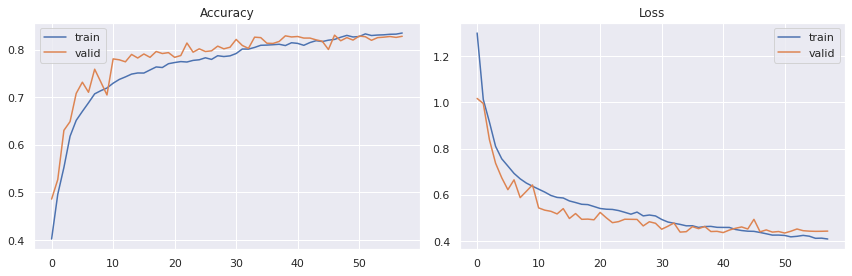

In [30]:
sns.set()
fig = pyplot.figure(0, (12, 4))

ax = pyplot.subplot(1, 2, 1)
sns.lineplot(history.epoch, history.history['accuracy'], label='train')
sns.lineplot(history.epoch, history.history['val_accuracy'], label='valid')
pyplot.title('Accuracy')
pyplot.tight_layout()

ax = pyplot.subplot(1, 2, 2)
sns.lineplot(history.epoch, history.history['loss'], label='train')
sns.lineplot(history.epoch, history.history['val_loss'], label='valid')
pyplot.title('Loss')
pyplot.tight_layout()

pyplot.savefig('epoch_history_dcnn.png')
pyplot.show()

    The epochs history shows that accuracy gradually increases and achieved +83% accuracy on both training and validation set, but at the end the model starts overfitting training data.

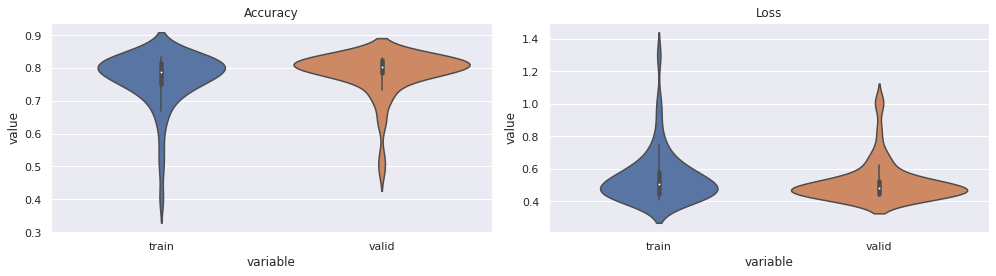

In [26]:
df_accu = pd.DataFrame({'train': history.history['accuracy'], 'valid': history.history['val_accuracy']})
df_loss = pd.DataFrame({'train': history.history['loss'], 'valid': history.history['val_loss']})

fig = pyplot.figure(0, (14, 4))
ax = pyplot.subplot(1, 2, 1)
sns.violinplot(x="variable", y="value", data=pd.melt(df_accu), showfliers=False)
pyplot.title('Accuracy')
pyplot.tight_layout()

ax = pyplot.subplot(1, 2, 2)
sns.violinplot(x="variable", y="value", data=pd.melt(df_loss), showfliers=False)
pyplot.title('Loss')
pyplot.tight_layout()

pyplot.savefig('performance_dist.png')
pyplot.show()

total wrong validation predictions: 361


              precision    recall  f1-score   support

           0       0.92      0.93      0.93       899
           1       0.82      0.71      0.76       608
           2       0.72      0.80      0.76       620

    accuracy                           0.83      2127
   macro avg       0.82      0.81      0.82      2127
weighted avg       0.83      0.83      0.83      2127



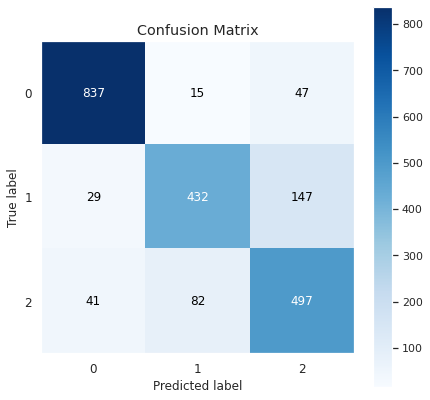

In [31]:
yhat_valid = model.predict_classes(X_valid)
scikitplot.metrics.plot_confusion_matrix(np.argmax(y_valid, axis=1), yhat_valid, figsize=(7,7))
pyplot.savefig("confusion_matrix_dcnn.png")

print(f'total wrong validation predictions: {np.sum(np.argmax(y_valid, axis=1) != yhat_valid)}\n\n')
print(classification_report(np.argmax(y_valid, axis=1), yhat_valid))

The confusion matrix clearly shows that our model is doing good job on the class `happy` but it's performance is low on other two classes. One of the reason for this could be the fact that these two classes have less data. But when I looked at the images I found some images from these two classes are even hard for a human to tell whether the person is sad or neutral. Facial expression depends on individual as well. Some person's neutral face looks like sad.

In [28]:
mapper = {
    0: "happy",
    1: "sad",
    2: "neutral",
}

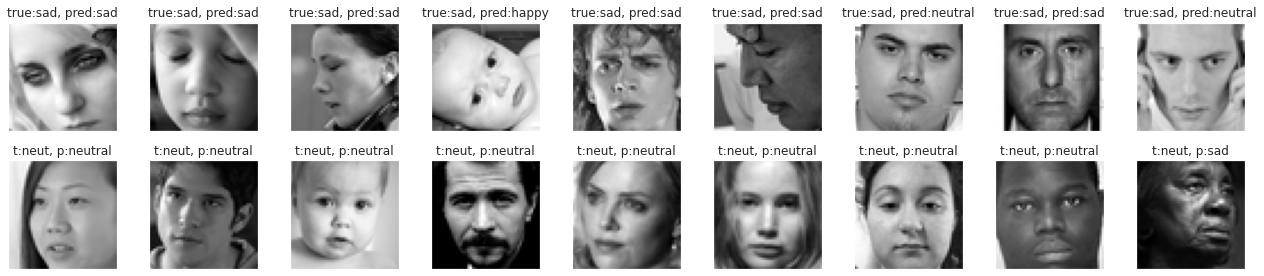

In [29]:
np.random.seed(2)
random_sad_imgs = np.random.choice(np.where(y_valid[:, 1]==1)[0], size=9)
random_neutral_imgs = np.random.choice(np.where(y_valid[:, 2]==1)[0], size=9)

fig = pyplot.figure(1, (18, 4))

for i, (sadidx, neuidx) in enumerate(zip(random_sad_imgs, random_neutral_imgs)):
        ax = pyplot.subplot(2, 9, i+1)
        sample_img = X_valid[sadidx,:,:,0]
        ax.imshow(sample_img, cmap='gray')
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(f"true:sad, pred:{mapper[model.predict_classes(sample_img.reshape(1,48,48,1))[0]]}")

        ax = pyplot.subplot(2, 9, i+10)
        sample_img = X_valid[neuidx,:,:,0]
        ax.imshow(sample_img, cmap='gray')
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(f"t:neut, p:{mapper[model.predict_classes(sample_img.reshape(1,48,48,1))[0]]}")

        pyplot.tight_layout()

See in the first row 7th image looks more like neutral rather than sad and our model even predicted it neutral. Whereas the last image in second row is very much sad.